In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import IPython.display
import os
import librosa
from pydub import AudioSegment as audio
from sklearn.decomposition import FastICA, PCA

/usr/local/lib/python2.7/dist-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


### FastICA using audio files ###

In [2]:
# obtain two audio files for comparison
arun = '/home/cc/Audio/Train/arun_alphabet.wav'
andrew = '/home/cc/Audio/Train/andrew_alphabet.wav'
arun_pydub = audio.from_wav(arun)
andrew_pydub = audio.from_wav(andrew)

In [3]:
# depending on which is longer, shorten to same length
if arun_pydub.duration_seconds > andrew_pydub.duration_seconds:
    arun_pydub = arun_pydub[0:int(andrew_pydub.duration_seconds)*1000]
    andrew_pydub = andrew_pydub[0:int(andrew_pydub.duration_seconds)*1000]
else:
    andrew_pydub = arun_pydub[0:int(arun_pydub.duration_seconds)*1000]
    arun_pydub = andrew_pydub[0:int(arun_pydub.duration_seconds)*1000]
print(arun_pydub.duration_seconds, andrew_pydub.duration_seconds)

(17.0, 17.0)


In [4]:
# now that the audio files are the same length, save them then import using librosa
andrew_pydub.export('audio_samples/andrew.wav', format='wav')
arun_pydub.export('audio_samples/arun.wav', format='wav')
arun, fs1 = librosa.load('audio_samples/arun.wav')
andrew, fs2 = librosa.load('audio_samples/andrew.wav')

In [5]:
# combine the two into one numpy array, add noise
S = np.c_[arun, andrew]

In [6]:
S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1], [0.5, 2], [1.5, 1.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

In [7]:
# Compute ICA
ica = FastICA(n_components=2)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

In [8]:
# For comparison, compute PCA
pca = PCA(n_components=2)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

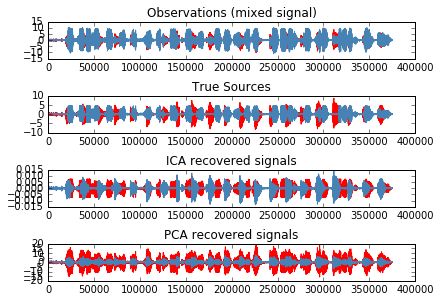

In [9]:
# graph it

plt.figure()

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals']
colors = ['red', 'steelblue']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.5, 1)
plt.show()

In [10]:
# separate ICA analysis into the two parts
ica1 = S_[:,0]
ica2 = S_[:,1]

In [11]:
IPython.display.Audio(ica1, rate=fs1)

In [12]:
IPython.display.Audio(ica2, rate=fs2)

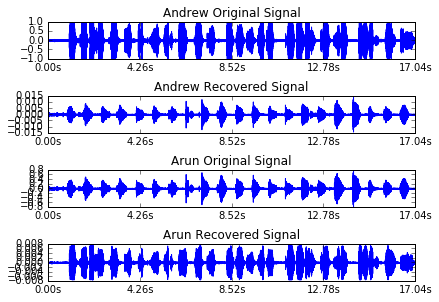

In [13]:
# plot both original and then separated audio files
plt.figure()
plt.subplot(4,1,1)
librosa.display.waveplot(andrew, sr=fs2)
plt.title('Andrew Original Signal')
plt.subplot(4,1,2)
librosa.display.waveplot(ica2, sr=fs2)
plt.title('Andrew Recovered Signal')
plt.subplot(4,1,3)
librosa.display.waveplot(arun, sr=fs1)
plt.title('Arun Original Signal')
plt.subplot(4,1,4)
librosa.display.waveplot(ica1, sr=fs1)
plt.title('Arun Recovered Signal')

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.5, 1)
plt.show()

#### As can be seen, two audio files containing speech can be separated using FastICA algorithm ####

### Going one step further, this is tried with a third speaker ###

In [14]:
mitha = '/home/cc/mitha_alphabet.wav'
mitha_pydub = audio.from_wav(mitha)

In [15]:
mitha_pydub = mitha_pydub[:int(andrew_pydub.duration_seconds)*1000]
print(mitha_pydub.duration_seconds)

17.0


In [16]:
mitha_pydub.export('audio_samples/mitha.wav', 'wav')
mitha, fs3 = librosa.load('audio_samples/mitha.wav')

In [17]:
# combine the two into one numpy array, add noise
S = np.c_[arun, andrew, mitha]
S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

In [18]:
# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

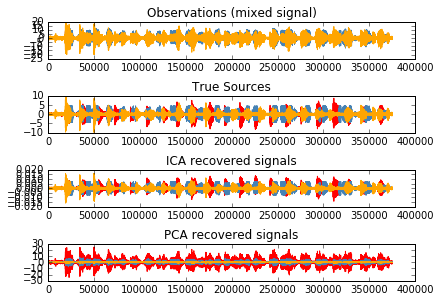

In [19]:
# graph it

plt.figure()

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.5, 1)
plt.show()

In [20]:
# separate into recovered audios
sep = []
sep.append(S_[:,0])
sep.append(S_[:,1])
sep.append(S_[:,2])

In [21]:
# resulting audio of the ICA separation
IPython.display.display(IPython.display.Audio(sep[0], rate=fs1))
IPython.display.display(IPython.display.Audio(sep[1], rate=fs2))
IPython.display.display(IPython.display.Audio(sep[2], rate=fs3))

In [22]:
# mixed audio for comparison. notice that they are completely mixed using the mixing array, as specified before
IPython.display.display(IPython.display.Audio(X[:,0], rate=fs1))
IPython.display.display(IPython.display.Audio(X[:,1], rate=fs2))
IPython.display.display(IPython.display.Audio(X[:,2], rate=fs3))